# Compare fingerprint-based scores to MCES
Here using pre-computed rascal MCES scores.
Those were computed for randomly selected pairs of compounds from the **ms2structures dataset** with a mass difference <= 100 Da (to avoid obviously distinct compounds).

In [1]:
import os
import sys
from pathlib import Path
import pickle
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.Chem import rdFingerprintGenerator

ROOT = Path(os.getcwd()).parents[0]

path_data = os.path.join(Path(ROOT), "data")

In [4]:
# Add source code path
sys.path.insert(0, os.path.join(ROOT, "src"))

# Import funtion/classes from source code
from fingerprint_computation import FingerprintGenerator, SparseFingerprintGenerator, compute_fingerprints_from_smiles
from metrics import generalized_tanimoto_similarity_matrix_sparse, jaccard_similarity_matrix_sparse
from metrics import generalized_tanimoto_similarity_matrix, jaccard_similarity_matrix

#from map4neo import MAP4neo
#from mapmorgan import MAP4Morgan

In [5]:
from typing import List
from rdkit.Chem import Mol
from map4 import MAP4
from mbp import MBP
#from map4neo import MAP4neo

def compute_map_fingerprints_from_smiles(smiles, map_generator):
    
    molecules: List[Mol] = [Chem.MolFromSmiles(s) for s in smiles]
    fingerprints_map: np.ndarray = map_generator.calculate_many(
        molecules,
        number_of_threads=32,
        verbose=True,
    )
    return list(fingerprints_map)


def compute_sparse_map_fingerprints_from_smiles(
    smiles,
    map_generator,
    count=False,
    ):
    molecules: List[Mol] = [Chem.MolFromSmiles(s) for s in smiles]
    fingerprints_map: np.ndarray = map_generator.calculate_many_sparse(
        molecules,
        number_of_threads=32,
        verbose=True,
        count=count,
    )
    return list(fingerprints_map)


def compute_sparse_map_fingerprints_from_smiles_serial(
        smiles,
        map_generator,
        count=False
        ):

    molecules: List[Mol] = [Chem.MolFromSmiles(s) for s in smiles]
    fingerprints = []
    for mol in tqdm(molecules):
        if count:
            fp = map_generator.calculate_sparse(mol, count=count)
            fingerprints.append(fp)
        else:
            fp_bits = map_generator._calculate(mol)
            fingerprints.append(np.sort(map_generator.encoder.hash(fp_bits)))
    return fingerprints

## Import ms2structures dataset and rascal scores

In [6]:
filename = "compounds_ms2structures.csv"
compounds = pd.read_csv(os.path.join(path_data, filename))
compounds.head()

,inchikey,smiles,mass,cf_class,cf_subclass,cf_superclass,formula,npc_class_results,npc_pathway_results,npc_superclass_results
0,AAAQFGUYHFJNHI,CCNC(=O)C[C@H]1C2=NN=C(N2C3=C(C=C(C=C3)OC)C(=N...,423.146204,Benzodiazepines,"1,4-benzodiazepines",Organoheterocyclic compounds,C22H22ClN5O2,NaN,Alkaloids,NaN
1,AABFWJDLCCDJJN,COC1=CC2=C(C=C1)NC3=C2C=CN=C3C4=CC=CC5=CC=CC=C54,324.126264,Harmala alkaloids,NaN,Alkaloids and derivatives,C22H16N2O,Carboline alkaloids,Alkaloids,Tryptophan alkaloids
2,AABILZKQMVKFHP,C/C=C(/C)\C(=O)O[C@H]1CC[N+]2([C@@H]1C(=CC2)CO...,427.220624,NaN,NaN,Alkaloids and derivatives,C21H33NO8,Pyrrolizidine alkaloids,Alkaloids,Ornithine alkaloids
3,AABUHSBGEIUSRJ,CC(=O)NC1=CC=C(C=C1)NC(=O)C=CC2=CC=CC=C2,280.120724,Cinnamic acids and derivatives,Cinnamic acid amides,Phenylpropanoids and polyketides,C17H16N2O2,Cinnamic acid amides,Shikimates and Phenylpropanoids,Phenylpropanoids (C6-C3)
4,AABUKWVVUWBZCS,C1=CC=C(C=C1)C2=C(C(=O)OC3=C2C=CC(=C3)O)C4=CC=...,314.094724,Neoflavonoids,Neoflavones,Phenylpropanoids and polyketides,C21H14O3,Neoflavonoids,Shikimates and Phenylpropanoids,Flavonoids


In [7]:
compounds.shape

(37811, 10)

In [8]:
rascal_scores = pd.read_csv(os.path.join(path_data, "rascal_benchmarking_set_250513.csv"))
rascal_scores.head()

,inchikey1,inchikey2,mass_diff,mass1,mass2,rascal,timeout
0,AAAQFGUYHFJNHI,ACNHBCIZLNNLRS,12.09472,423.146204,435.240924,0.038877,False
1,AAAQFGUYHFJNHI,ACQNDKXMOBGYKN,83.05148,423.146204,340.094724,0.059829,False
2,AAAQFGUYHFJNHI,AHHKLTZSMVVPOJ,97.00092,423.146204,326.145284,0.082928,False
3,AAAQFGUYHFJNHI,AJJHWJZAMWDEKK,6.01142,423.146204,429.157624,0.136461,False
4,AAAQFGUYHFJNHI,AKEJXNSCRNEUTK,70.61000,423.904000,494.514000,0.102407,False


In [9]:
rascal_scores.shape

(5557963, 7)

In [10]:
rascal_scores.value_counts("timeout")

timeout
False    5413677
True      144286
Name: count, dtype: int64

<Axes: >

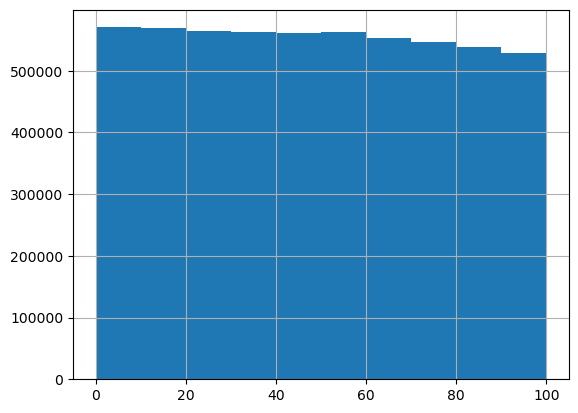

In [11]:
rascal_scores.mass_diff.hist()

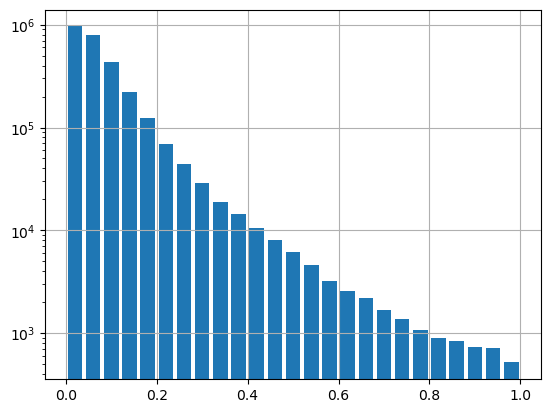

In [12]:
mask = (rascal_scores.timeout == False) & (rascal_scores.mass_diff <=50)

fig, ax = plt.subplots()
ax = rascal_scores[mask].rascal.hist(bins=25, rwidth=0.8)
ax.set_yscale("log")

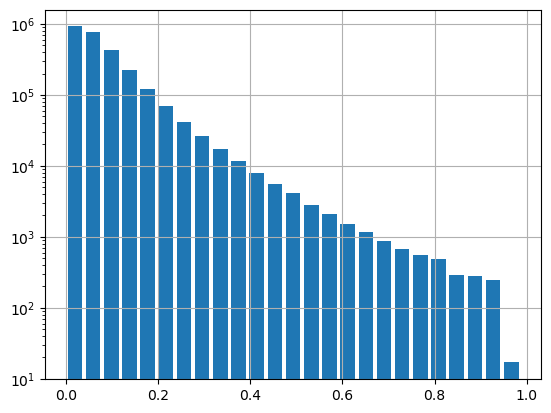

In [13]:
mask = (rascal_scores.timeout == False) & (rascal_scores.mass_diff > 50)

fig, ax = plt.subplots()
ax = rascal_scores[mask].rascal.hist(bins=25, rwidth=0.8)
ax.set_yscale("log")

In [14]:
rascal_scores.loc[~rascal_scores['timeout']].shape

(5413677, 7)

In [15]:
rascal_scores.loc[~rascal_scores['timeout']].dropna().shape

(5413677, 7)

# Compare MCES to fingerprint based scores

In [16]:
compounds_mapper = compounds.copy()
compounds_mapper["index"] = compounds_mapper.index
compounds_mapper = compounds_mapper.set_index("inchikey")
compounds_mapper = compounds_mapper.iloc[:, -1]
compounds_mapper

inchikey
AAAQFGUYHFJNHI        0
AABFWJDLCCDJJN        1
AABILZKQMVKFHP        2
AABUHSBGEIUSRJ        3
AABUKWVVUWBZCS        4
                  ...  
ZZYXNRREDYWPLN    37806
ZZZJZEXRSVMPPV    37807
ZZZQXCUPAJFVBN    37808
ZZZRUAITSXLWBH    37809
ZZZYHIMVKOHVIH    37810
Name: index, Length: 37811, dtype: int64

## Run experiments

In [17]:
experiments = [
    ("rdkit", rdFingerprintGenerator.GetRDKitFPGenerator(fpSize=4096), False),
    ("rdkit_sparse", rdFingerprintGenerator.GetRDKitFPGenerator(fpSize=4096), False),
    ("rdkit_count", rdFingerprintGenerator.GetRDKitFPGenerator(fpSize=4096), True),
    ("rdkit_count_sparse", rdFingerprintGenerator.GetRDKitFPGenerator(fpSize=4096), True),
    ("morgan3", rdFingerprintGenerator.GetMorganGenerator(radius=3, fpSize=4096), False),
    ("morgan9", rdFingerprintGenerator.GetMorganGenerator(radius=9, fpSize=4096), False),
    ("morgan12", rdFingerprintGenerator.GetMorganGenerator(radius=12, fpSize=4096), False),
    ("morgan3_sparse", rdFingerprintGenerator.GetMorganGenerator(radius=3, fpSize=4096), False),
    ("morgan9_sparse", rdFingerprintGenerator.GetMorganGenerator(radius=9, fpSize=4096), False),
    ("morgan12_sparse", rdFingerprintGenerator.GetMorganGenerator(radius=12, fpSize=4096), False),
    ("morgan3_count", rdFingerprintGenerator.GetMorganGenerator(radius=3, fpSize=4096), True),
    ("morgan9_count", rdFingerprintGenerator.GetMorganGenerator(radius=9, fpSize=4096), True),
    ("morgan12_count", rdFingerprintGenerator.GetMorganGenerator(radius=12, fpSize=4096), True),
    ("morgan3_count_sparse", rdFingerprintGenerator.GetMorganGenerator(radius=3, fpSize=4096), True),
    ("morgan9_count_sparse", rdFingerprintGenerator.GetMorganGenerator(radius=9, fpSize=4096), True),
    ("morgan12_count_sparse", rdFingerprintGenerator.GetMorganGenerator(radius=12, fpSize=4096), True),
    ("rdkit_logcount", rdFingerprintGenerator.GetRDKitFPGenerator(fpSize=4096), True),
    ("morgan3_logcount", rdFingerprintGenerator.GetMorganGenerator(radius=3, fpSize=4096), True),
    ("morgan9_logcount", rdFingerprintGenerator.GetMorganGenerator(radius=9, fpSize=4096), True),
    ("morgan12_logcount", rdFingerprintGenerator.GetMorganGenerator(radius=12, fpSize=4096), True),
    ("rdkit_logcount_sparse", rdFingerprintGenerator.GetRDKitFPGenerator(fpSize=4096), True),
    ("morgan3_logcount_sparse", rdFingerprintGenerator.GetMorganGenerator(radius=3, fpSize=4096), True),
    ("morgan9_logcount_sparse", rdFingerprintGenerator.GetMorganGenerator(radius=9, fpSize=4096), True),
    ("morgan12_logcount_sparse", rdFingerprintGenerator.GetMorganGenerator(radius=12, fpSize=4096), True),
    ("map2", MAP4(dimensions=4096, radius=1, include_duplicated_shingles=False), False),
    ("map4", MAP4(dimensions=4096, radius=2, include_duplicated_shingles=False), False),
    ("map2_sparse", MAP4(dimensions=4096, radius=1, include_duplicated_shingles=False), False),
    ("map4_sparse", MAP4(dimensions=4096, radius=2, include_duplicated_shingles=False), False),
    #("mbp2", MBP(dimensions=4096, radius=1), False),
    #("mbp2_binned", MBP(dimensions=4096, radius=1, dist_binning=np.array([0, 1, 2, 4, 8, 16, 32, 64])), False),
    #("mbp2_count", MBP(dimensions=4096, radius=1), True),
    #("mbp2_binned_count", MBP(dimensions=4096, radius=1, dist_binning=np.array([0, 1, 2, 4, 8, 16, 32, 64])), True),
    #("mbp2_sparse", MBP(dimensions=4096, radius=1), False),
    #("mbp2_binned_sparse", MBP(dimensions=4096, radius=1, dist_binning=np.array([0, 1, 2, 4, 8, 16, 32, 64])), False),
    #("mbp2_count_sparse", MBP(dimensions=4096, radius=1), True),
    #("mbp2_binned_count_sparse", MBP(dimensions=4096, radius=1, dist_binning=np.array([0, 1, 2, 4, 8, 16, 32, 64])), True),
    #("mbp2_logcount_sparse", MBP(dimensions=4096, radius=1), True),
    #("mbp2_binned_logcount_sparse", MBP(dimensions=4096, radius=1, dist_binning=np.array([0, 1, 2, 4, 8, 16, 32, 64])), True),
]

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.patheffects as path_effects
from mpl_toolkits.axes_grid1 import make_axes_locatable


def heatmap_comparison_flat(similarities1, similarities2, label1, label2, bins=50,
                       colormap="viridis",
                       add_region_percentage=True, filename=None,
                      ):
    """
    Generates a heatmap comparison of two similarity matrices.
    
    Parameters:
    similarities1 (ndarray): First similarity array.
    similarities2 (ndarray): Second similarity array.
    label1 (str): Label for the x-axis.
    label2 (str): Label for the y-axis.
    bins (int, optional): Number of bins for the 2D histogram (default: 50).
    colormap (str, optional): Colormap used for visualization (default: "viridis").
    filename (str, optional): If provided, saves the heatmap to the specified file.
    """
    # Create figure and axis
    fig, ax = plt.subplots(figsize=(8, 8), dpi=300)
    
    # Select upper triangle indices to ignore diagonal if necessary
    n = similarities1.shape[0]
    
    # Compute the 2D histogram
    hist, x_edges, y_edges = np.histogram2d(
        similarities1, 
        similarities2, 
        bins=bins
    )
    
    # Plot the heatmap using imshow with a logarithmic color scale
    im = ax.imshow(
        hist.T, origin='lower', aspect='equal',
        extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]],
        cmap=colormap, norm=LogNorm(vmin=1, vmax=np.max(hist))
    )
    
    # Create an axis of the same height for the colorbar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cb = fig.colorbar(im, cax=cax)
    cb.set_label("Count")
    
    # Compute total count for percentage calculations
    total_count = len(similarities1)
    
    # Add text annotations for each 5x5 section of bins
    step = bins // 5
    for i in range(0, bins, step):
        for j in range(0, bins, step):
            sub_matrix = hist[i:i+step, j:j+step]
            subsection_sum = np.sum(sub_matrix)
            
            if subsection_sum > 0 and add_region_percentage:
                # Compute the center of the bin for text placement
                x_center = (x_edges[i] + x_edges[min(i + step, bins - 1)]) / 2
                y_center = (y_edges[j] + y_edges[min(j + step, bins - 1)]) / 2
                
                # Add text annotation
                ax.text(
                    x_center, y_center, f"{(100 * subsection_sum / total_count):.2f}%",
                    color="white", ha="center", va="center", fontsize=6, zorder=2
                )
    
    # Configure grid, labels, and layout
    ax.grid(True, zorder=1)
    ax.set_xlabel(label1)
    ax.set_ylabel(label2)
    plt.tight_layout()
    
    # Save plot if a filename is provided
    if filename:
        plt.savefig(filename)
    
    # Show the plot
    plt.show()

In [19]:
path_results = os.path.join(Path(ROOT), "experiments", "rascal_correlation")

In [20]:
from metrics import jaccard_index, jaccard_index_sparse, generalized_tanimoto_similarity, generalized_tanimoto_similarity_sparse_numba

In [21]:
import numpy as np
import pandas as pd
from scipy.stats import pearsonr, spearmanr, kendalltau

def compare_scores(
    result_df: pd.DataFrame,
    fingerprints,
    metric_function,
    label1: str,
    label2: str,
    filename: str,
    plot_heatmap: bool = True,
    scaling: str = None,
    rascal_min: float = None
) -> dict:
    """
    Compare fingerprint-based similarities against rascalMCES
    using Pearson, Spearman, Kendall, and Concordance Correlation;
    optionally only on pairs with rascal >= rascal_min.

    Parameters
    ----------
    result_df : pd.DataFrame
        Must contain columns 'inchikey1','inchikey2','rascal','timeout'.
    fingerprints : Sequence
        Each element either a single‐FP array or a tuple (raw_fp, val_fp).
    metric_function : callable
        If single‐FP: metric(fp_i, fp_j).
        If tuple‐FP: metric(raw_i,val_i,raw_j,val_j).
    label1, label2 : str
        Labels for the axes in the heatmap.
    filename : str
        Where to save heatmap (pass None to skip saving).
    scaling : {None, 'log'}
        If 'log', applies np.log1p to fingerprint inputs.
    rascal_min : float, optional
        If set, only keep pairs with rascal >= rascal_min.

    Returns
    -------
    dict
        {
          'pearson': r,
          'spearman': rho,
          'kendall' : tau,
          'ccc'     : concordance_ccc
        }
    """
    # 1) filter timeouts + NaNs
    df = result_df.loc[~result_df['timeout']].copy().fillna(0.0)
    
    # 2) optionally filter by rascal threshold
    if rascal_min is not None:
        before = len(df)
        df = df.loc[df['rascal'] >= rascal_min]
        after = len(df)
        print(f"– Filtering to rascal ≥ {rascal_min}: {before} → {after} pairs")

    # 3) pull out rascal vector
    rascal = df['rascal'].values

    # 4) map inchikey → index via compounds_mapper
    idx1 = compounds_mapper.loc[df['inchikey1']].values
    idx2 = compounds_mapper.loc[df['inchikey2']].values

    # 5) compute fingerprint similarities
    fpsims = []
    for i, j in zip(idx1, idx2):
        fi, fj = fingerprints[i], fingerprints[j]

        if scaling == 'log':
            # apply log‐scaling to the 'value' part or to the whole fp
            if isinstance(fi, tuple):
                raw_i, val_i = fi
                raw_j, val_j = fj
                val_i, val_j = np.log1p(val_i), np.log1p(val_j)
                sim = metric_function(raw_i, val_i, raw_j, val_j)
            else:
                sim = metric_function(np.log1p(fi), np.log1p(fj))
        else:
            if isinstance(fi, tuple):
                sim = metric_function(fi[0], fi[1], fj[0], fj[1])
            else:
                sim = metric_function(fi, fj)

        fpsims.append(sim)
    fpsims = np.array(fpsims)

    # 6) compute correlations
    r,  p_r  = pearsonr(rascal, fpsims)
    rho, p_s = spearmanr(rascal, fpsims)
    tau, p_k = kendalltau(rascal, fpsims)

    # Lin’s CCC
    mean_r, mean_f = rascal.mean(), fpsims.mean()
    var_r, var_f   = rascal.var(ddof=1), fpsims.var(ddof=1)
    cov_rf         = np.cov(rascal, fpsims, ddof=1)[0,1]
    ccc = 2 * cov_rf / (var_r + var_f + (mean_r - mean_f)**2)

    # 7) report
    print(f"Pearson   r = {r:.4f} (p={p_r:.2e})")
    print(f"Spearman  ρ = {rho:.4f} (p={p_s:.2e})")
    print(f"Kendall   τ = {tau:.4f} (p={p_k:.2e})")
    print(f"Concordance CCC = {ccc:.4f}")

    if plot_heatmap:
        # 8) heatmap / scatter
        heatmap_comparison_flat(
            rascal, fpsims,
            f"{label1}" + (f" (≥{rascal_min})" if rascal_min is not None else ""),
            label2,
            filename=filename
        )

    return {
        'pearson':  r,
        'spearman': rho,
        'kendall':  tau,
        'ccc':      ccc
    }


In [22]:
filename = os.path.join(path_results, "results_rascal_correlations_250512.csv")

results_df = pd.read_csv(filename)
results = list(results_df.T.to_dict().values())

## Run experiments (if not found in file)

----- Found existing results for experiment: rdkit -----
----- (experiment will be skipped) -----

----- Found existing results for experiment: rdkit_sparse -----
----- (experiment will be skipped) -----

----- Experiment: rdkit_count -----


100%|███████████████████████████████████| 37811/37811 [00:36<00:00, 1044.92it/s]


Collected 37811 dense fingerprints.
Pearson   r = 0.6066 (p=0.00e+00)
Spearman  ρ = 0.5103 (p=0.00e+00)
Kendall   τ = 0.3583 (p=0.00e+00)
Concordance CCC = 0.5788


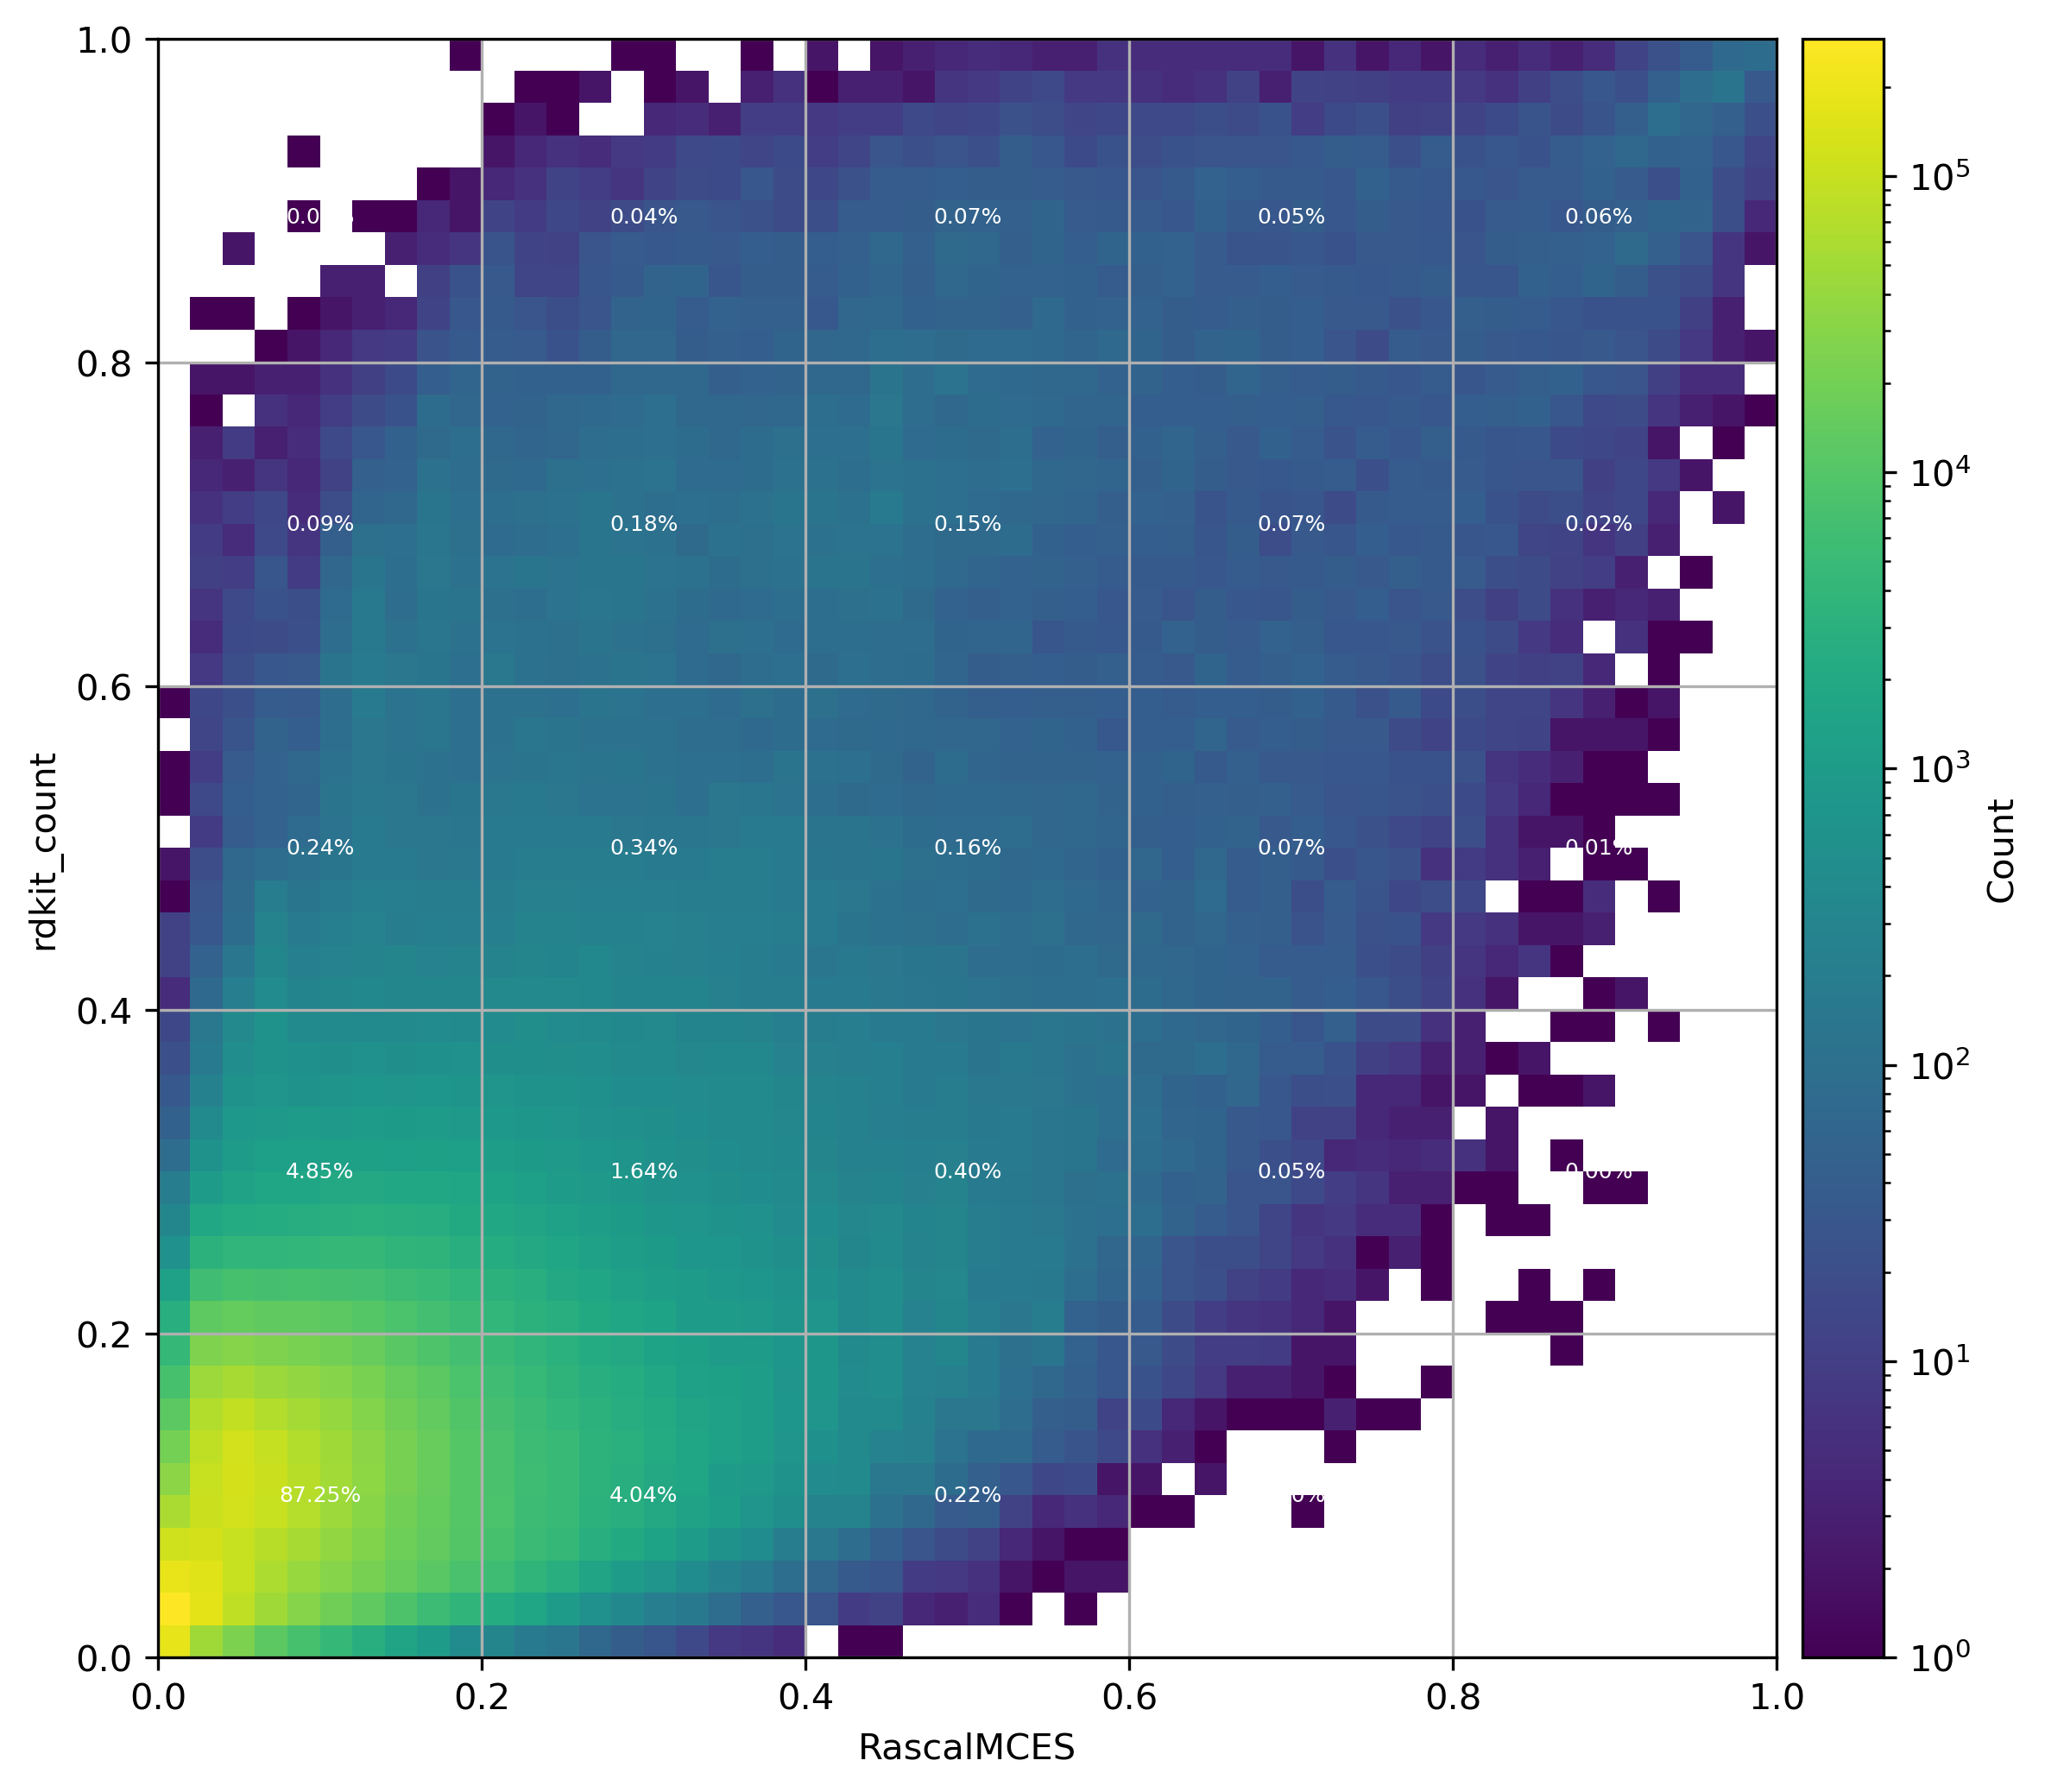

Results for rdkit_count:
  Pearson r = 0.60656
  Spearman ρ = 0.51030
  Kendall τ = 0.35829
  Concordance CCC = 0.57879

----- Experiment: rdkit_count_sparse -----


100%|████████████████████████████████████| 37811/37811 [00:44<00:00, 851.62it/s]


Collected 37811 sparse fingerprints.
Pearson   r = 0.6863 (p=0.00e+00)
Spearman  ρ = 0.6796 (p=0.00e+00)
Kendall   τ = 0.5005 (p=0.00e+00)
Concordance CCC = 0.6602


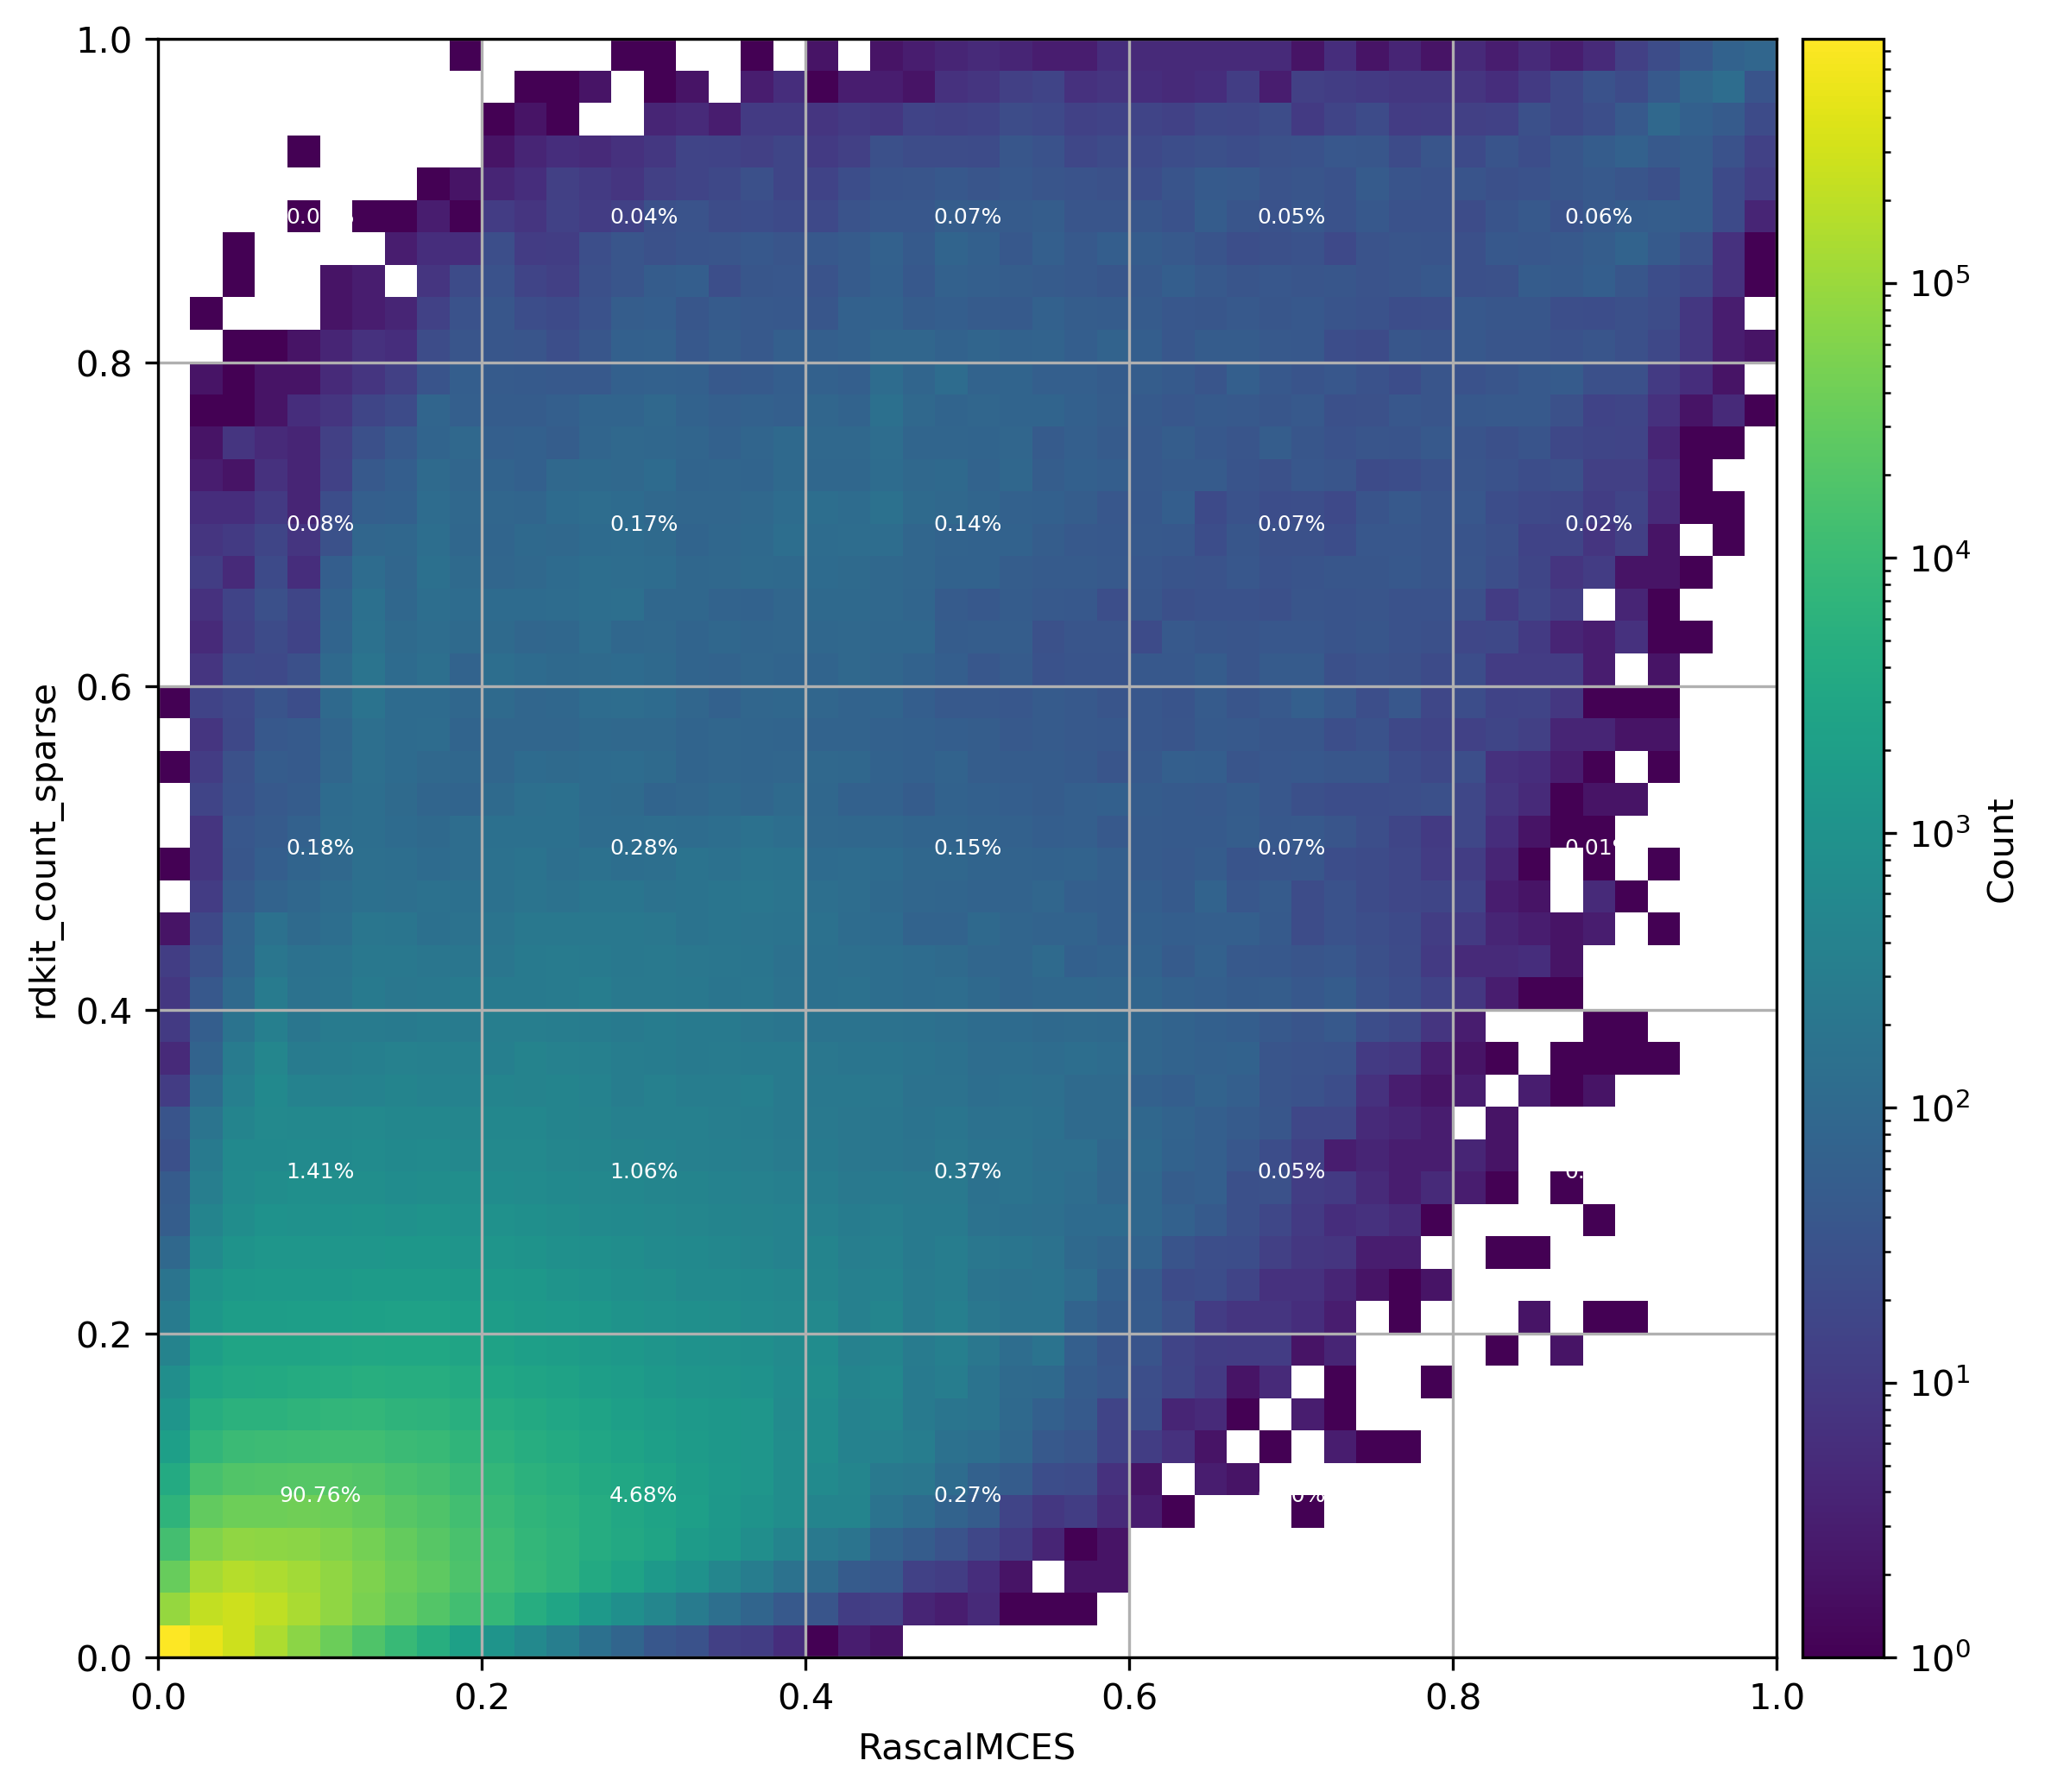

Results for rdkit_count_sparse:
  Pearson r = 0.68633
  Spearman ρ = 0.67960
  Kendall τ = 0.50052
  Concordance CCC = 0.66020

----- Found existing results for experiment: morgan3 -----
----- (experiment will be skipped) -----

----- Found existing results for experiment: morgan9 -----
----- (experiment will be skipped) -----

----- Found existing results for experiment: morgan12 -----
----- (experiment will be skipped) -----

----- Found existing results for experiment: morgan3_sparse -----
----- (experiment will be skipped) -----

----- Found existing results for experiment: morgan9_sparse -----
----- (experiment will be skipped) -----

----- Found existing results for experiment: morgan12_sparse -----
----- (experiment will be skipped) -----

----- Found existing results for experiment: morgan3_count -----
----- (experiment will be skipped) -----

----- Found existing results for experiment: morgan9_count -----
----- (experiment will be skipped) -----

----- Found existing results 

100%|████████████████████████████████████| 37811/37811 [00:42<00:00, 895.55it/s]


Collected 37811 dense fingerprints.
Pearson   r = 0.5430 (p=0.00e+00)
Spearman  ρ = 0.4210 (p=0.00e+00)
Kendall   τ = 0.2920 (p=0.00e+00)
Concordance CCC = 0.4745


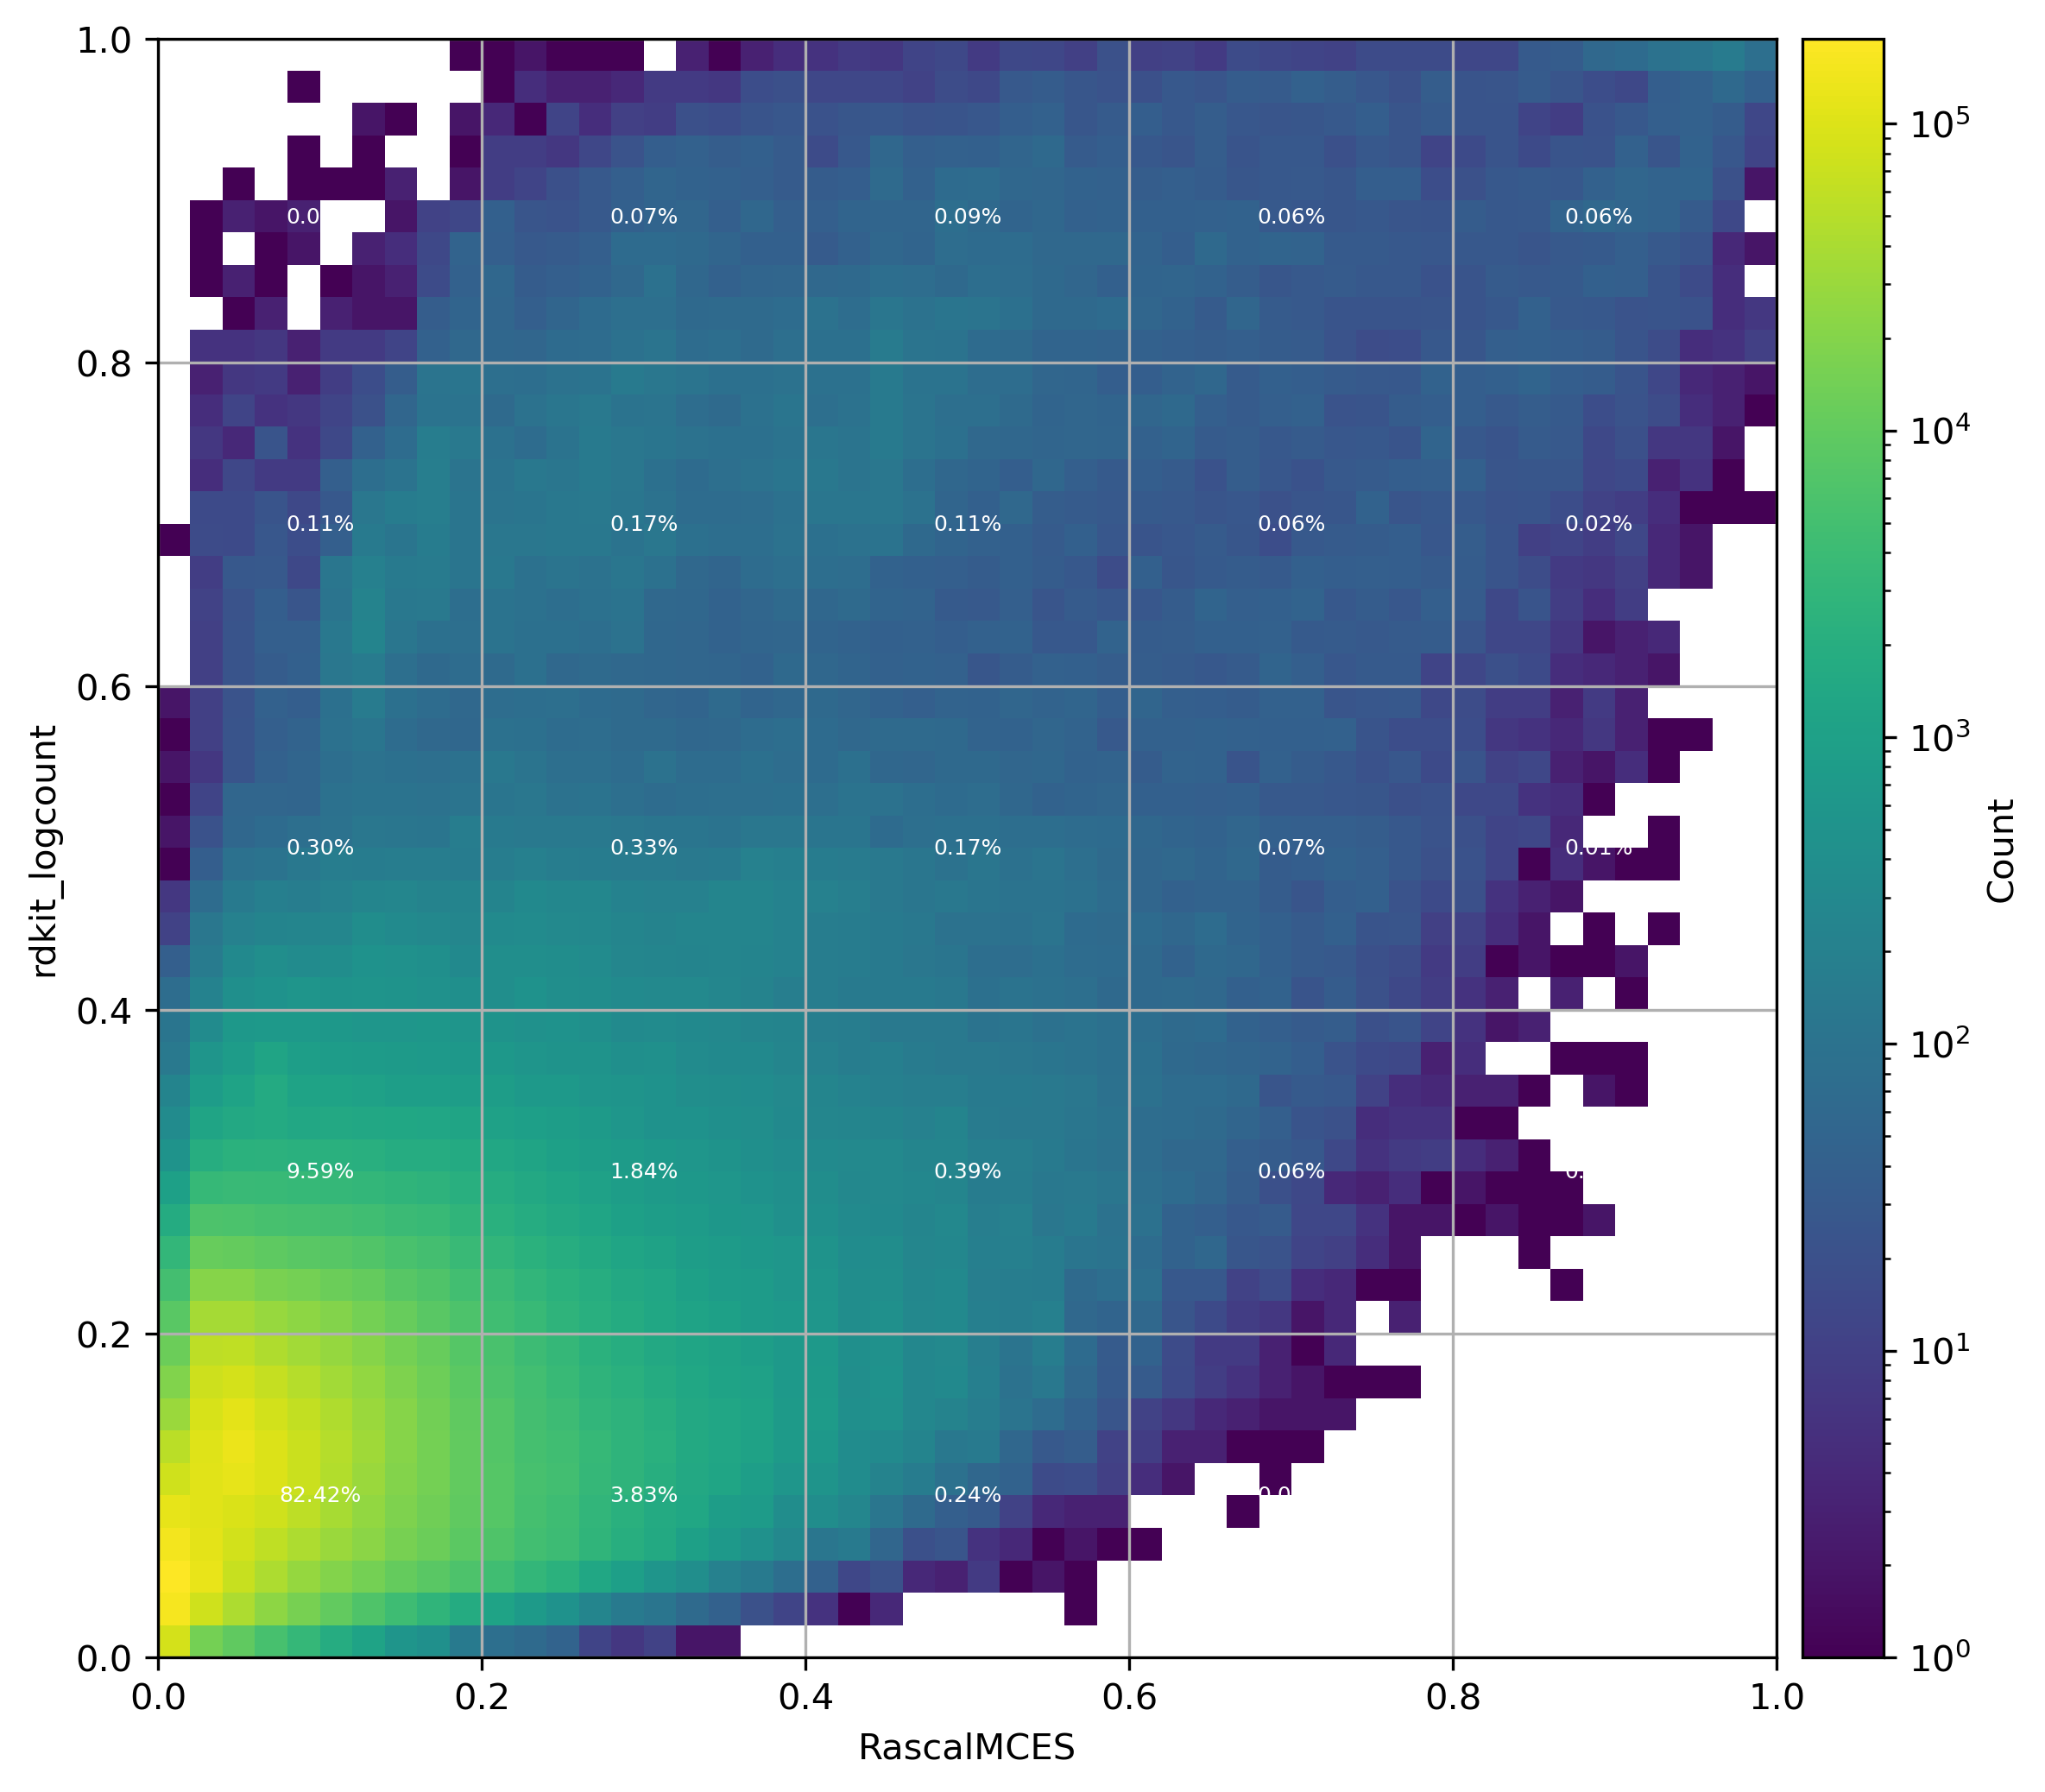

Results for rdkit_logcount:
  Pearson r = 0.54298
  Spearman ρ = 0.42102
  Kendall τ = 0.29201
  Concordance CCC = 0.47448

----- Found existing results for experiment: morgan3_logcount -----
----- (experiment will be skipped) -----

----- Found existing results for experiment: morgan9_logcount -----
----- (experiment will be skipped) -----

----- Found existing results for experiment: morgan12_logcount -----
----- (experiment will be skipped) -----

----- Experiment: rdkit_logcount_sparse -----


100%|████████████████████████████████████| 37811/37811 [00:46<00:00, 816.04it/s]


Collected 37811 sparse fingerprints.
Pearson   r = 0.6684 (p=0.00e+00)
Spearman  ρ = 0.6707 (p=0.00e+00)
Kendall   τ = 0.4937 (p=0.00e+00)
Concordance CCC = 0.6418


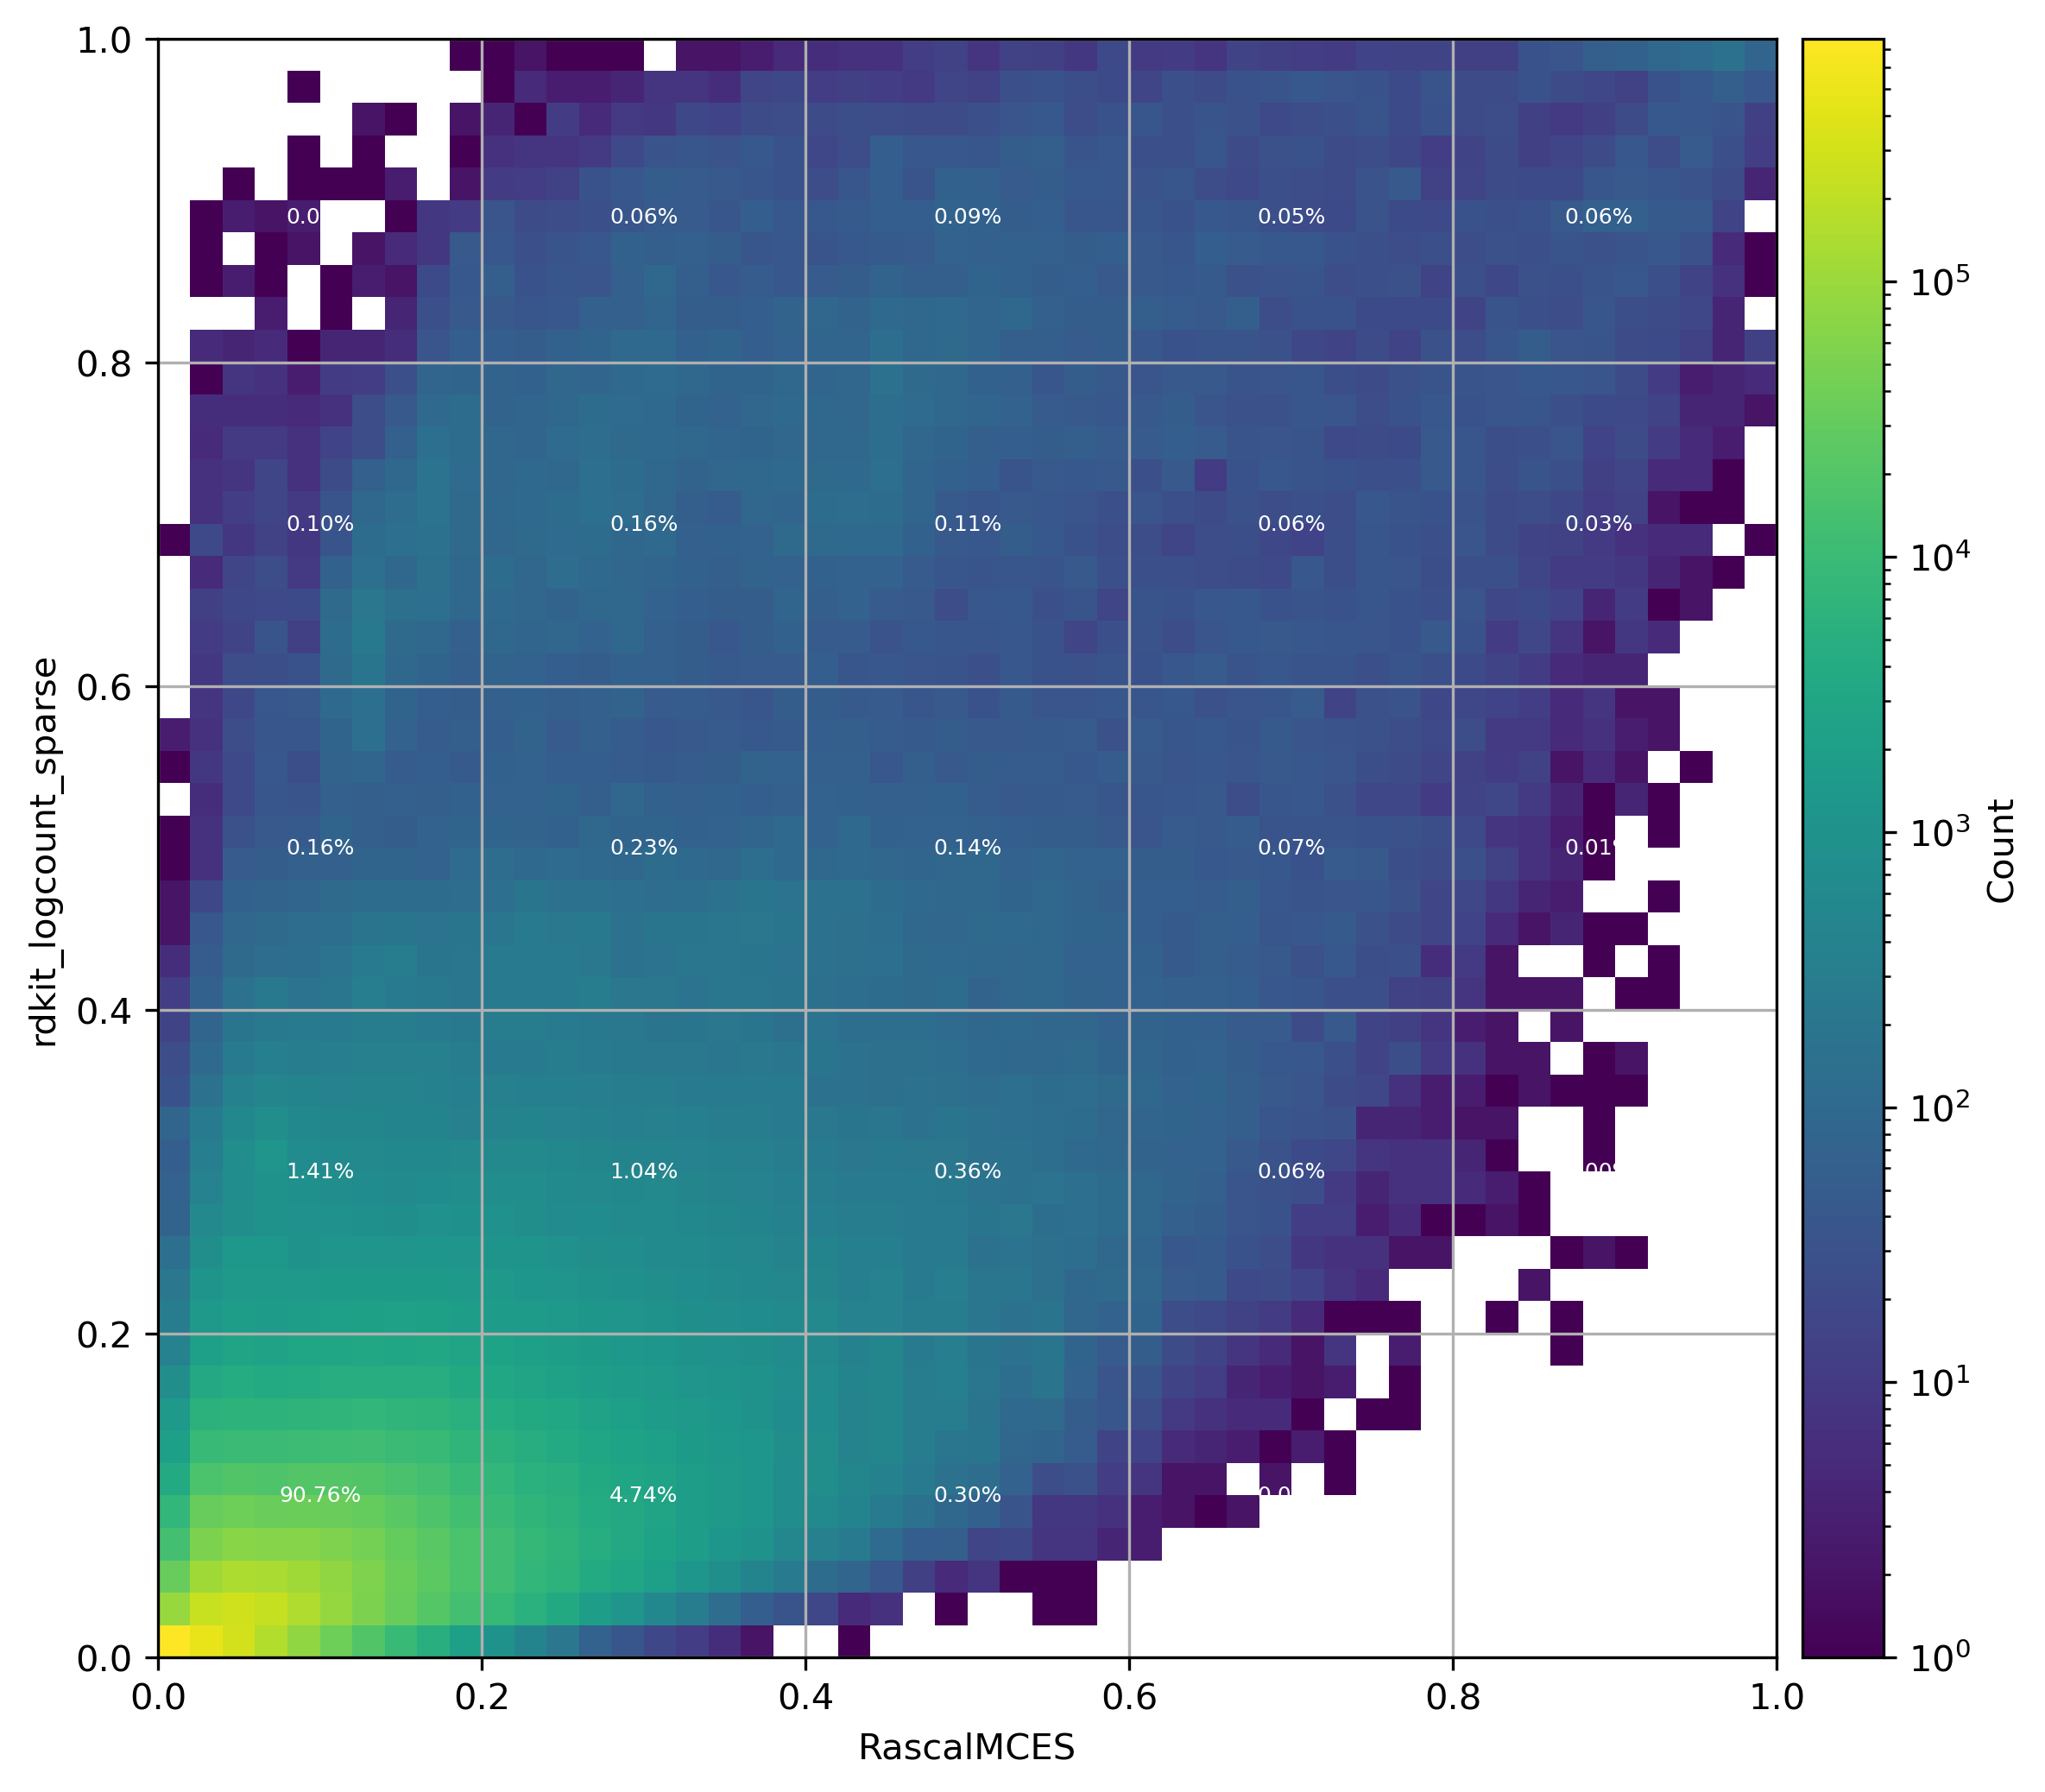

Results for rdkit_logcount_sparse:
  Pearson r = 0.66842
  Spearman ρ = 0.67071
  Kendall τ = 0.49369
  Concordance CCC = 0.64176

----- Found existing results for experiment: morgan3_logcount_sparse -----
----- (experiment will be skipped) -----

----- Found existing results for experiment: morgan9_logcount_sparse -----
----- (experiment will be skipped) -----

----- Found existing results for experiment: morgan12_logcount_sparse -----
----- (experiment will be skipped) -----

----- Found existing results for experiment: map2 -----
----- (experiment will be skipped) -----

----- Found existing results for experiment: map4 -----
----- (experiment will be skipped) -----

----- Found existing results for experiment: map2_sparse -----
----- (experiment will be skipped) -----

----- Found existing results for experiment: map4_sparse -----
----- (experiment will be skipped) -----

Wrote summary to /home/daisy/Florian/molecular_fingerprint_comparisons/experiments/rascal_correlation/results_r

In [23]:
FILENAME = "results_rascal_correlations_250924.csv"

#results = []

for experiment in experiments:
    name, fpgen, count = experiment

    # where we'll save the heatmap
    plot_filename = os.path.join(path_results, f"{name}_rascal_comparison.png")

    if os.path.exists(plot_filename):
        print(f"----- Found existing results for experiment: {name} -----")
        print("----- (experiment will be skipped) -----\n")
        continue

    print(f"----- Experiment: {name} -----")

    # determine if we need log‐scaling
    scaling = "log" if "logcount" in name else None

    # 1) compute / load fingerprints
    if "_sparse" in name:
        if "map" in name:
            fingerprints = compute_sparse_map_fingerprints_from_smiles_serial(
                compounds.smiles, fpgen, count=count
            )
        elif "mbp" in name:
            fingerprints = compute_sparse_map_fingerprints_from_smiles(
                compounds.smiles, fpgen, count=count
            )
        else:
            fingerprints = compute_fingerprints_from_smiles(
                compounds.smiles, fpgen,
                sparse=True, count=count, progress_bar=True
            )
        print(f"Collected {len(fingerprints)} sparse fingerprints.")
    else:
        if ("map" in name) or ("mbp" in name):
            fingerprints = compute_map_fingerprints_from_smiles(
                compounds.smiles, fpgen
            )
            fingerprints = np.stack(fingerprints)
        else:
            fingerprints = compute_fingerprints_from_smiles(
                compounds.smiles, fpgen,
                sparse=False, count=count, progress_bar=True
            )
            fingerprints = np.stack(fingerprints)
        print(f"Collected {fingerprints.shape[0]} dense fingerprints.")

    # 2) pick the right similarity metric
    if "_sparse" in name:
        metric = generalized_tanimoto_similarity_sparse_numba if "count" in name else jaccard_index_sparse
    else:
        metric = generalized_tanimoto_similarity if "count" in name else jaccard_index

    # 3) run the comparison
    metrics = compare_scores(
        rascal_scores,
        fingerprints,
        metric,
        label1="RascalMCES",
        label2=name,
        filename=plot_filename,
        scaling=scaling
    )

    # 4) report to console
    print(f"Results for {name}:")
    print(f"  Pearson r = {metrics['pearson']:.5f}")
    print(f"  Spearman ρ = {metrics['spearman']:.5f}")
    print(f"  Kendall τ = {metrics['kendall']:.5f}")
    print(f"  Concordance CCC = {metrics['ccc']:.5f}\n")

    # 5) record for CSV
    record = {"experiment": name}
    record.update(metrics)
    results.append(record)

# after all experiments, dump to CSV
results_df = pd.DataFrame(results)
filename = os.path.join(path_results, FILENAME)
results_df.to_csv(filename, index=False)
print(f"Wrote summary to {filename}")

In [24]:
filename = os.path.join(path_results, "results_rascal_correlations_250924.csv")

results_df = pd.read_csv(filename)
results_df = results_df.set_index("experiment")
results_df.sort_values("kendall", ascending=False)

,pearson,spearman,kendall,ccc
experiment,,,,
rdkit_count_sparse,0.686326,0.679603,0.500524,0.660197
rdkit_logcount_sparse,0.668424,0.670713,0.493688,0.641762
rdkit_sparse,0.641534,0.643092,0.470765,0.614070
morgan12_logcount_sparse,0.682281,0.609998,0.438663,0.488352
morgan9_logcount_sparse,0.679329,0.607671,0.436914,0.509262
map4_sparse,0.563984,0.595072,0.433341,0.281649
map2_sparse,0.593747,0.585599,0.426127,0.416015
morgan12_sparse,0.677314,0.582979,0.417075,0.408883
morgan12_count_sparse,0.641747,0.585872,0.416928,0.542825


In [28]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D


def plot_tau_comparison(tau_series, title="", filename=None):
    """
    Create a comparison plot of Kendall's tau for dense vs. sparse variants,
    with a legend for the two marker types.
    
    Parameters
    ----------
    tau_series : pd.Series
        Index are experiment names, values are Kendall tau.
    filename : str or None
        If provided, save figure to this path.
        
    Returns
    -------
    fig : matplotlib.figure.Figure
    """
    # 1) Group into dense vs. sparse by base name
    groups = {}
    for name, tau in tau_series.items():
        if name.endswith('_sparse'):
            base = name[:-7]
            groups.setdefault(base, {})['sparse'] = tau
        else:
            groups.setdefault(name, {})['dense'] = tau

    # 2) Determine sort order by max tau in each group, ascending
    sorted_bases = sorted(
        groups.keys(),
        key=lambda base: max(groups[base].values()),
        reverse=False
    )
    
    # 3) Plot
    fig, ax = plt.subplots(figsize=(8, len(sorted_bases) * 0.4))
    y_positions = list(range(len(sorted_bases)))
    for y, base in zip(y_positions, sorted_bases):
        vals = groups[base]
        if 'dense' in vals and 'sparse' in vals:
            ax.plot([vals['dense'], vals['sparse']], [y, y], ":", color="black", linewidth=2)
        if 'dense' in vals:
            ax.plot(vals['dense'], y, marker='o', color="crimson")
        if 'sparse' in vals:
            ax.plot(vals['sparse'], y, marker='s', color="teal")

    all_taus = [tau
            for vals in groups.values()
            for tau in vals.values()]
    # only draw zero‐line if any tau ≤ 0
    if min(all_taus) <= 0:
        ax.axvline(0, linestyle='--', linewidth=1.5, color='black')

    # 5) Labels and ticks
    ax.set_yticks(y_positions)
    names_cleaned = [x.replace("_", " ").replace("logcount", "log count") for x in sorted_bases]
    ax.set_yticklabels(names_cleaned)
    ax.set_xlabel("Kendall's $τ_B$")
    ax.set_title(title)
    ax.grid(True)

    # 6) Legend
    legend_elements = [
        Line2D([0], [0], marker='o', color='crimson', linestyle='None', label='4096 bit fingerprint'),
        Line2D([0], [0], marker='s', color='teal',   linestyle='None', label='sparse fingerprint')
    ]
    ax.legend(handles=legend_elements, loc='lower left')

    plt.tight_layout()

    # 7) Save or show
    if filename:
        fig.savefig(filename, dpi=450)
    plt.show()

    return fig


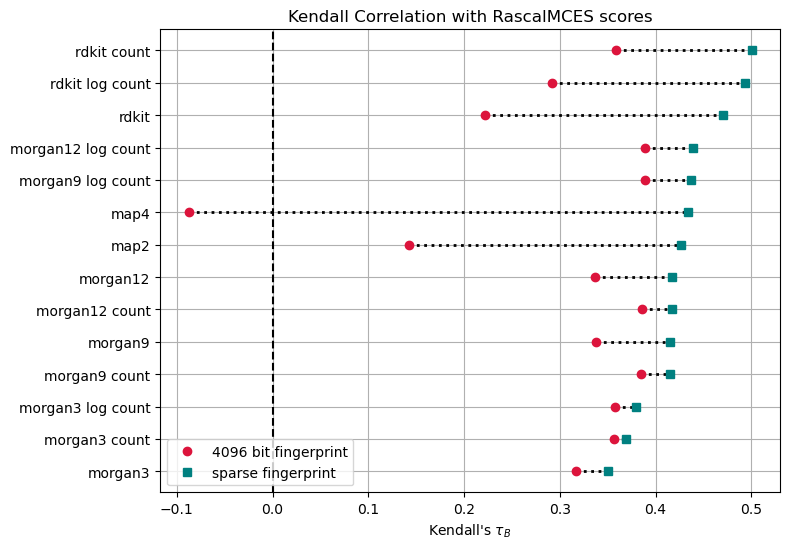

In [29]:
plot_tau_comparison(
    results_df.kendall,
    "Kendall Correlation with RascalMCES scores",
    "rascal_kendall_correlation_full.png"
)
plt.show()